In [3]:
import torch #librairy used in building NN models, Tensors and Training (why we need pytorch in logistic/softmax regression ? -> bec we are dealign with images which will transformed into matrices/vectors of large dims (for example the images in MNSIT dataset has dims 28*28=784px which mean 784 feature to be learned) this will lead to large number of matrices operations numpy uses only CPU while tensor in pytorch use the cuda cores in gpu to accelrate the matrices operations
import torchvision #library that provides datasets like MNIST and transforms
import torchvision.transforms as transforms # transforms are used in data preprocessing
from sklearn.model_selection import train_test_split  #to split the data into (train / validation / test)
from torch.utils.data import DataLoader, TensorDataset #TensorDataset: link between features and labels ##DataLoader:divide data into batches
import matplotlib.pyplot as plt #for plotting curves
from sklearn.metrics import confusion_matrix , accuracy_score #to evaluate model and make confusion matrix
from IPython.display import clear_output #to clear old output to see the live score while in training loop


#if flatten is True means transform the image from a 28*28 Matrix(2D) to 784*1 Vector(1D)
#Flatten is necessary in logistic and softmax regression bec they are linear models in which z = W.X + B where X is 1 Dim vector
def load_mnist_data(flatten=False, batch_size=64):
    # Load datasets
    transform = transforms.ToTensor() #transform image from Numpy to pytorch tensor and make the values of each pixel between 0 and 1
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True # create a folder called data and store in it the data
    )#Train =true -> get 60k image to train # Train= false -> get 10k images to test
    test_dataset = torchvision.datasets.MNIST(#download=True -> download the data if not in /data folder
        root='./data', train=False, transform=transform, download=True
    )

    # Convert to numpy for splitting
    # float32 ensures numeric type, /255 normalizes pixels
    x_train = train_dataset.data.numpy().astype('float32') / 255.0 #the original value of each pexil is in range (0 to 255) by using .astype('float32') we convert it to a value suitable for neural netowrks
    y_train = train_dataset.targets.numpy()
    x_test  = test_dataset.data.numpy().astype('float32') / 255.0
    y_test  = test_dataset.targets.numpy()

    # Flatten for linear models
    if flatten:
        # shape[0] = num of imgs, -1 lets numpy infer(predict) the last last dimension (784)
        x_train = x_train.reshape(x_train.shape[0], -1) #reshape is the function used to covert the data from 28*28 matrix to 784*1 vector
        x_test  = x_test.reshape(x_test.shape[0], -1) #.shape is a fn that returns the dims #shape[0] return number of rows
        #x_train.shape = (6000,28,28) after reshape (6000,784)
    else:
        # Add channel dimension (for grayscale CNNs/NNs)
        x_train = x_train[:, None, :, :]
        x_test  = x_test[:, None, :, :]
        #None -> add new dim for the grayscale channel

    # Split train into train + validation
    # test_size=0.25 → 75% train, 25% val (→ about 60/20/20 overall)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.25, stratify=y_train, random_state=42
    )

    # Convert numpy arrays to PyTorch tensors
    X_train_t = torch.tensor(x_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t   = torch.tensor(x_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.long)
    X_test_t  = torch.tensor(x_test, dtype=torch.float32)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoaders #dataloader is an object used in splitting data into batches and shuffle (reorder data randomly in each epoch) and used in itiration
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True) #TensorDataset(X_train_t, y_train_t) create a tensor from x_train and y_train
    val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [4]:
#binary logistic regression
def logistic_regression(train_loader, val_loader, test_loader, digit1=0, digit2=1, lr=0.01, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks if there are cuda cores (gpu) available to be used if not just use the cpu

    # Filter datasets for binary classification
    # choose only images with lablel 0 or 1 and in the lists x and y
    def filter_loader(loader):
        x_list, y_list = [], []
        for x, y in loader:
            mask = (y == digit1) | (y == digit2)
            x_list.append(x[mask])
            y_list.append((y[mask] == digit2).long())  # digit1=0, digit2=1
        return torch.cat(x_list), torch.cat(y_list)

    x_train, y_train = filter_loader(train_loader)
    x_val, y_val = filter_loader(val_loader)
    x_test, y_test = filter_loader(test_loader)

    # Flatten input if needed (e.g., for linear models)
    if len(x_train.shape) > 2:
        x_train = x_train.view(x_train.shape[0], -1)
        x_val = x_val.view(x_val.shape[0], -1)
        x_test = x_test.view(x_test.shape[0], -1)
    #logistic regression model definiton
    input_size = x_train.shape[1]
    w = torch.zeros((input_size, 1), requires_grad=True, device=device) #requires_grad=True means calc the gradient while back propagation
    b = torch.zeros(1, requires_grad=True, device=device) #device=device use gpu if exists
    optimizer = torch.optim.SGD([w, b], lr=lr)  # Optional: Replace manual updates

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        # Training
        z = x_train.to(device) @ w + b #x_train.to(device) put the train data in the device (gpu/cpu)
        y_pred = torch.sigmoid(z).squeeze() #.squeeze() getrid of extra dims for example (N,1) -> (N,)
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_train.to(device).float()) #.float() to make sure that prediction is a float number
        loss.backward() #to calc gradients from back propagation
        optimizer.step()  # Or manual updates #optimizers uses the calculated gradients from the back propagation to update the weights so that the model can learn and get better
        optimizer.zero_grad()

        pred_train = (y_pred > 0.5).long() # means if probability > 0,5 -> predict 1 else predict 0
        acc_train = (pred_train == y_train.to(device)).float().mean().item() # create list based on the comparison between pred_train and y_train -> [1,0,0,0,1,0,1,1,1,.....] calc its mean and convert from tensor to float to be printed

        # Validation
        with torch.no_grad():
            z_val = x_val.to(device) @ w + b
            y_val_pred = torch.sigmoid(z_val).squeeze()
            loss_val = torch.nn.functional.binary_cross_entropy(y_val_pred, y_val.to(device).float())
            acc_val = ((y_val_pred > 0.5).long() == y_val.to(device)).float().mean().item()

        train_losses.append(loss.item())
        val_losses.append(loss_val.item())
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}, "
              f"Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}")

    # Test evaluation
    with torch.no_grad():
        z_test = x_test.to(device) @ w + b
        y_test_pred = torch.sigmoid(z_test).squeeze()
        preds_test = (y_test_pred > 0.5).long().cpu().numpy()
        acc_test = accuracy_score(y_test.numpy(), preds_test)
        cm = confusion_matrix(y_test.numpy(), preds_test)

    print(f"\nTest Accuracy: {acc_test:.4f}")
    print(f"Confusion Matrix (0={digit1}, 1={digit2}):\n{cm}")

    return train_losses, val_losses, train_accs, val_accs


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import clear_output

def logistic_regression_multiclass(train_loader, val_loader, test_loader, lr=0.01, epochs=10): #Softmax regression
    # Set device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Combine all batches into single tensors and ensure they're flattened
    def loader_to_tensor(loader):
        x_list, y_list = [], []
        for x, y in loader:
            x_list.append(x.view(x.size(0), -1))  # Force flattening
            y_list.append(y)
        return torch.cat(x_list), torch.cat(y_list)

    # Load and flatten data
    x_train, y_train = loader_to_tensor(train_loader)
    x_val, y_val = loader_to_tensor(val_loader)
    x_test, y_test = loader_to_tensor(test_loader)

    # Initialize parameters (Xavier initialization)
    input_size = x_train.shape[1]  # 784 for MNIST
    num_classes = 10               # Digits 0-9

    # Use nn.Parameter for weights and biases
    W = nn.Parameter(torch.randn((input_size, num_classes), device=device) * 0.01)
    b = nn.Parameter(torch.zeros(num_classes, device=device))
    #why not just initailize w and b with zeros ?
    #because here we have 10 labels so if we started with w=0 and b=0 then softmax will give all classes 1/10 prediction and the gradients will be identical so the model won't be able to distinguish between numbers


    # Use an optimizer
    optimizer = torch.optim.SGD([W, b], lr=lr) #update the weights using the gradients calculated from back propagation

    # Training tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        # ---- Training ----
        Z = x_train.to(device) @ W + b
        loss = F.cross_entropy(Z, y_train.to(device))  # More stable than manual

        # Backpropagation
        loss.backward()
        optimizer.step() # Use optimizer to update weights and biases
        optimizer.zero_grad() # Clear gradients

        # Calculate accuracy
        preds_train = Z.argmax(dim=1) #argmax vs softmax -> softmax:takes the score and transform it to probability # argmax: takes the class of the heighest score and predict upon it
        acc_train = (preds_train == y_train.to(device)).float().mean().item()

        # ---- Validation ----
        with torch.no_grad():
            Z_val = x_val.to(device) @ W + b
            loss_val = F.cross_entropy(Z_val, y_val.to(device))
            preds_val = Z_val.argmax(dim=1)
            acc_val = (preds_val == y_val.to(device)).float().mean().item()

        # Store metrics
        train_losses.append(loss.item())
        val_losses.append(loss_val.item())
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        # Dynamic plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.legend()
        plt.title('Accuracy Curves')
        plt.show()

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}, '
              f'Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}')

    # ---- Final Test Evaluation ----
    with torch.no_grad():
        Z_test = x_test.to(device) @ W + b
        preds_test = Z_test.argmax(dim=1).cpu().numpy()

    acc_test = accuracy_score(y_test.numpy(), preds_test)
    cm = confusion_matrix(y_test.numpy(), preds_test)

    print(f'\nFinal Test Accuracy: {acc_test:.4f}')
    print('Confusion Matrix:')
    print(cm)

    return {
        'weights': W.cpu().detach(),
        'biases': b.cpu().detach(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accuracy': acc_test
    }

In [6]:
# Load the MNIST data for binary classification (flatten=True for logistic regression)
train_loader_binary, val_loader_binary, test_loader_binary = load_mnist_data(flatten=True)

# Train the binary logistic regression model for digits 0 and 1
logistic_regression(train_loader_binary, val_loader_binary, test_loader_binary, digit1=0, digit2=1, epochs=5)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.22MB/s]


Epoch 1/5: Train Loss: 0.6931, Val Loss: 0.6611, Train Acc: 0.4677, Val Acc: 0.9867
Epoch 2/5: Train Loss: 0.6609, Val Loss: 0.6320, Train Acc: 0.9915, Val Acc: 0.9886
Epoch 3/5: Train Loss: 0.6317, Val Loss: 0.6053, Train Acc: 0.9922, Val Acc: 0.9889
Epoch 4/5: Train Loss: 0.6050, Val Loss: 0.5809, Train Acc: 0.9929, Val Acc: 0.9902
Epoch 5/5: Train Loss: 0.5805, Val Loss: 0.5584, Train Acc: 0.9933, Val Acc: 0.9915

Test Accuracy: 0.9972
Confusion Matrix (0=0, 1=1):
[[ 980    0]
 [   6 1129]]


([0.6931474208831787,
  0.6609430313110352,
  0.6316787004470825,
  0.6049635410308838,
  0.5804640650749207],
 [0.6610990762710571,
  0.631960928440094,
  0.6053476929664612,
  0.5809305906295776,
  0.5584318041801453],
 [0.46767741441726685,
  0.9914718866348267,
  0.9922088980674744,
  0.9929459095001221,
  0.9932617545127869],
 [0.9867382645606995,
  0.9886327981948853,
  0.9889485239982605,
  0.990211546421051,
  0.9914745688438416])

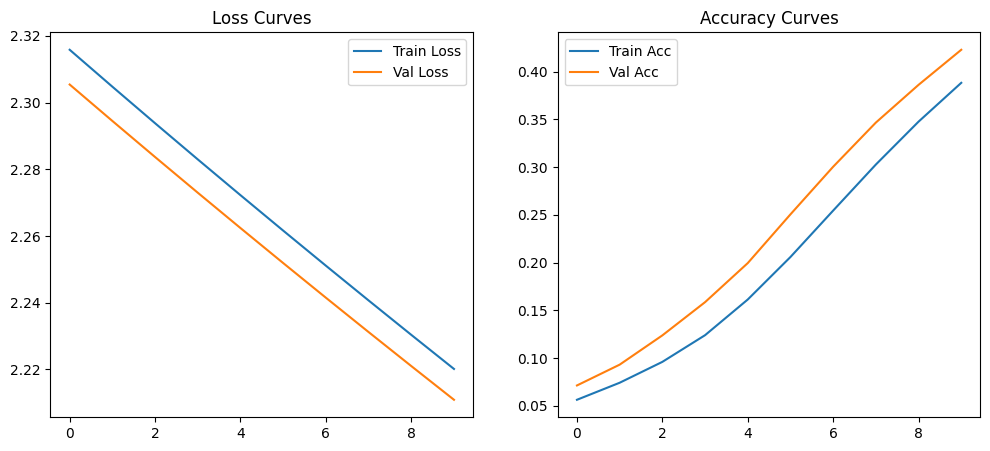

Epoch 10/10: Train Loss: 2.2201, Val Loss: 2.2109, Train Acc: 0.3883, Val Acc: 0.4229

Final Test Accuracy: 0.4157
Confusion Matrix:
[[767   0  33  84  19   3  24   2   4  44]
 [  0 594  29 129  14   3 112   1 252   1]
 [ 46  15 460  90  11   1 302   5  46  56]
 [  3   3  66 313   3  18 277   8 307  12]
 [ 56   2 171   6 345   3  97  93 189  20]
 [ 62   2  47  82 121  37 160  15 356  10]
 [ 93   6 127  11  66   2 596  16  13  28]
 [ 47   7  38  12  31  28  40 452 253 120]
 [ 45  11  62 108 133   2 201   6 403   3]
 [ 64   1  31  18 185   4 100  34 382 190]]


{'weights': tensor([[ 0.0075,  0.0055,  0.0134,  ..., -0.0011,  0.0058,  0.0049],
         [ 0.0096,  0.0001,  0.0021,  ...,  0.0002, -0.0137, -0.0049],
         [ 0.0053,  0.0132,  0.0061,  ...,  0.0047, -0.0050, -0.0155],
         ...,
         [-0.0095,  0.0131, -0.0140,  ..., -0.0066, -0.0003, -0.0168],
         [-0.0032,  0.0073, -0.0011,  ..., -0.0021,  0.0085,  0.0197],
         [ 0.0002,  0.0008, -0.0074,  ..., -0.0113,  0.0029, -0.0107]]),
 'biases': tensor([ 3.0969e-04,  1.6095e-03, -2.7861e-04,  1.5290e-04, -5.8195e-04,
         -5.5914e-04, -8.7746e-04,  5.3341e-04, -3.3559e-04,  2.7214e-05]),
 'train_losses': [2.3158490657806396,
  2.3047709465026855,
  2.2938108444213867,
  2.2829654216766357,
  2.272230386734009,
  2.2616026401519775,
  2.2510786056518555,
  2.2406561374664307,
  2.2303311824798584,
  2.220102548599243],
 'val_losses': [2.305421829223633,
  2.294491767883301,
  2.283674716949463,
  2.2729673385620117,
  2.262367010116577,
  2.2518694400787354,
  2.241472

In [7]:
# Load the MNIST data for multiclass classification (flatten=True for logistic regression)
train_loader_multiclass, val_loader_multiclass, test_loader_multiclass = load_mnist_data(flatten=True)

# Train the multiclass logistic regression model
logistic_regression_multiclass(train_loader_multiclass, val_loader_multiclass, test_loader_multiclass, epochs=10)